## RetinaNet

Link to the paper: https://arxiv.org/pdf/1708.02002.pdf

In [1]:
#1
from fastai.conv_learner import *
from matplotlib import patches, patheffects
from collections import defaultdict

## Loading the relevant files

In [2]:
#2
coco_path = Path('/scratch/arka/Ark_git_files/coco/')
ann_path = coco_path / 'annotations'
train_path = coco_path / 'train2017'
val_path = coco_path / 'val2017'

In [ ]:
!ls {ann_path}

In [ ]:
# captions_train2017 = json.load((ann_path / 'captions_train2017.json').open('r'))
# captions_val2017 = json.load((ann_path / 'captions_val2017.json').open('r'))
instances_train2017 = json.load((ann_path / 'instances_train2017.json').open('r'))
instances_val2017 = json.load((ann_path / 'instances_val2017.json').open('r'))
# person_keypoints_train2017 = json.load((ann_path / 'person_keypoints_train2017.json').open('r'))
# person_keypoints_val2017 = json.load((ann_path / 'person_keypoints_val2017.json').open('r'))

In [ ]:
instances_train2017.keys()

In [3]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

### Saving relevant files

In [ ]:
train_df_list = []
# print(instances_train2017['annotations'][0]['image_id'])
# instances_train2017['annotations'][0]['id']
for d in tqdm(instances_train2017['annotations']):
    iid = d['id']
    image_id = d['image_id']
    bbox = d['bbox']
    cat_id = d['category_id']
    train_df_list.append([iid, image_id, bbox, cat_id])
train_df = pd.DataFrame(train_df_list, columns=['id','image_id', 'bbox', 'category_id'])

In [ ]:
val_df_list = []
# print(instances_train2017['annotations'][0]['image_id'])
# instances_train2017['annotations'][0]['id']
for d in tqdm(instances_val2017['annotations']):
    iid = d['id']
    image_id = d['image_id']
    bbox = d['bbox']
    cat_id = d['category_id']
    val_df_list.append([iid, image_id, bbox, cat_id])
val_df = pd.DataFrame(val_df_list, columns=['id','image_id', 'bbox', 'category_id'])

In [ ]:
train_df2_list = list()
bbx_dict = defaultdict(list)
cat_dict = defaultdict(list)
for d in tqdm(instances_train2017['annotations']):
    iid = d['id']
    image_id = d['image_id']
    bbox = d['bbox']
    cat_id = d['category_id']
    bbx_dict[image_id].append(bbox)
    cat_dict[image_id].append(cat_id)
for imgi, bbox_list in tqdm(bbx_dict.items()):
    train_df2_list.append([imgi, bbox_list, cat_dict[imgi]])
train_df2 = pd.DataFrame(train_df2_list, columns=['image_id', 'bbox', 'category_id'])

In [ ]:
val_df2_list = list()
bbx_dict = defaultdict(list)
cat_dict = defaultdict(list)
for d in tqdm(instances_val2017['annotations']):
    iid = d['id']
    image_id = d['image_id']
    bbox = d['bbox']
    cat_id = d['category_id']
    bbx_dict[image_id].append(bbox)
    cat_dict[image_id].append(cat_id)
for imgi, bbox_list in tqdm(bbx_dict.items()):
    val_df2_list.append([imgi, bbox_list, cat_dict[imgi]])
val_df2 = pd.DataFrame(val_df2_list, columns=['image_id', 'bbox', 'category_id'])

In [4]:
# 3
CSVS = coco_path / 'CSVS'
CSVS2 = coco_path / 'CSVS2'
CSV3 = coco_path / 'CSV3'

CSVS.mkdir(exist_ok=True)
CSVS2.mkdir(exist_ok=True)
CSV3.mkdir(exist_ok=True)

train_csv = CSVS / 'train.csv'
val_csv = CSVS / 'val.csv'

train2_csv = CSVS2 / 'train.csv'
val2_csv = CSVS2 / 'val.csv'

train3_csv = CSV3 / 'train_bbx.csv'
val3_csv = CSV3 / 'val_bbx.csv'


train4_csv = CSV3 / 'train_cid.csv'
val4_csv = CSV3 / 'val_cid.csv'

category_mapping = coco_path / 'category_map.json'
inv_category_mapping = coco_path / 'inv_category_map.json'

In [ ]:
# train_df.to_csv(train_csv, header=True, index=False)
# val_df.to_csv(val_csv, header=True, index=False)
train_df2.to_csv(train2_csv, header=True, index=False)
val_df2.to_csv(val2_csv, header=True, index=False)
# train_df3.to_csv(train3_csv, header=True, index=False)
# val_df3.to_csv(val3_csv, header=True, index=False)

# train_df4.to_csv(train4_csv, header=True, index=False)
# val_df4.to_csv(val4_csv, header=True, index=False)

In [ ]:
cmap = dict()
inv_cmap = dict()
for i in instances_train2017['categories']:
    cmap[i['id']] = i['name']
    inv_cmap[i['name']] = i['id']

In [ ]:
json.dump(cmap, category_mapping.open('w'))
json.dump(inv_cmap, inv_category_mapping.open('w'))

In [ ]:
train_bbx_list = []
train_cid_list = []
for t in tqdm(train_df.iterrows(), total=len(train_df)):
    train_bbx_list.append(['{:012}'.format(t[1]['image_id']), re.sub('[^A-Za-z0-9. ]+', '', t[1]['bbox'])])
    train_cid_list.append(['{:012}'.format(t[1]['image_id']), re.sub('[^A-Za-z0-9. ]+', '', t[1]['category_id'])])
train_df3 = pd.DataFrame(train_bbx_list, columns=['image_id', 'bbox'])
train_df4 = pd.DataFrame(train_cid_list, columns=['image_id', 'cid'])

In [ ]:
val_bbx_list = []
val_cid_list = []
for t in tqdm(val_df.iterrows(), total=len(val_df)):
    val_bbx_list.append(['{:012}'.format(t[1]['image_id']), re.sub('[^A-Za-z0-9. ]+', '', t[1]['bbox'])])
    val_cid_list.append(['{:012}'.format(t[1]['image_id']), re.sub('[^A-Za-z0-9. ]+', '', t[1]['category_id'])])
val_df3 = pd.DataFrame(val_bbx_list, columns=['image_id', 'bbox'])
val_df4 = pd.DataFrame(val_cid_list, columns=['image_id', 'cid'])

### Loading relevant files

In [6]:
# 4
# train_df = pd.read_csv(train_csv, header='infer')
# val_df = pd.read_csv(val_csv, header='infer')
train_df = pd.read_csv(train2_csv, header='infer')
val_df = pd.read_csv(val2_csv, header='infer')
# train_df = pd.read_csv(train3_csv, header='infer')
# val_df = pd.read_csv(val3_csv, header='infer')


cat_map = json.load(category_mapping.open('r'))
inv_cat_map = json.load(inv_category_mapping.open('r'))

### Creating Dataset and Dataloader

In [280]:
tbx = train_df['bbox']
tbx = tbx.apply(ast.literal_eval)

In [284]:
tbx = tbx.apply(np.array)

In [291]:
tmp = []
for t in tbx:
    tmp.append(t.shape[0])
np.max(tmp)
np.argmax(tmp)

82092

In [ ]:
??BaseDataset

In [7]:
# 5
catlist = []
cat2lab = dict()
lab2cat = dict()
c = 0
for i, v in cat_map.items():
    catlist.append(int(i))
    cat2lab[int(i)] = c
    lab2cat[c] = int(i)
    c += 1

In [265]:
import ast
class CocoDS(BaseDataset):
    def __init__(self, df, tdir, sz=224, tfm1=None):
        # ['id', 'image_id', 'bbox', 'category_id']
        self.df = df
        self.tdir = tdir        
        self.n = self.get_n()
        self.c = self.get_c()
        self.sz = sz
        # tfm1 for bbox
        self.tfm1 = tfm1
        
    def get_n(self):
        return len(self.df)
    
    def get_c(self):
        return 80
    
    def get_sz(self):
        return self.sz
    
    def get_x(self, i):
        fid = '{:012}'.format(self.df.iloc[i]['image_id']) + '.jpg'
        fname = self.tdir / fid
        return open_image(fname)
    
#     def get_y(self, i):
#         y_bbox = ast.literal_eval(self.df.iloc[i]['bbox'])
#         cat_id = ast.literal_eval(self.df.iloc[i]['category_id'])
#         y_ids = [cat2lab[cid]  for cid in cat_id]
# #         y_bbox = [hw_bb(np.array(y_bb)) for y_bb in y_bbox]
#         y_bbox_tmp = []
#         for y_bb in y_bbox:
#             if len(y_bb) != 4:
#                 y_bb = y_bb[0]
#             y_bbox_tmp.append(hw_bb(np.array(y_bb)))
#         return (y_bbox_tmp, y_ids)

    
#     def __getitem__(self, idx):
#         x,y = self.get_x(idx),self.get_y(idx)
#         y1 = [self.tfm1(x, z)[1] for z in y[0]]
#         x, _ = self.tfm1(x, y[0][0])
#         return x, (y1, y[1])

    def __getitem__(self, idx):
        x = self.get_x(idx)
        y_bbox = ast.literal_eval(self.df.iloc[idx]['bbox'])
        cat_id = ast.literal_eval(self.df.iloc[idx]['category_id'])
        ylist = []
        xout, _ = self.tfm1(x, hw_bb(y_bbox[0]))
#         import pdb; pdb.set_trace()
        for ind, cid in enumerate(cat_id):
            y_bb = y_bbox[ind]
            _, tmp = self.tfm1(x, hw_bb(y_bb))
            ylist.append((tmp, cid))
        
        return xout, ylist
    
    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.
        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.tfm1.denorm(np.rollaxis(arr,1,4))

In [266]:
imagenet_stats = A([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
sz = 224
# tfms = tfms_from_stats(imagenet_stats, sz, aug_tfms=transforms_basic, tfm_y=TfmType.COORD)
bs = 32
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]
tfms = tfms_from_stats(imagenet_stats, sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=TfmType.COORD)
trn_ds = CocoDS(train_df, train_path, sz, tfms[0])
fix_ds = CocoDS(train_df, train_path, sz, tfms[1])
# trn_dl = DataLoader(trn_ds, batch_size=bs)
val_ds = CocoDS(val_df, val_path, sz, tfms[1])
aug_ds = CocoDS(val_df, val_path, sz, tfms[0])
ds = [trn_ds, val_ds, fix_ds, aug_ds, None, None]
# val_dl = DataLoader(val_ds, batch_size=bs)

In [267]:
x, y = fix_ds[0]

In [268]:
x1, y1 = fix_ds[3]

In [269]:
fix_dl = DataLoader(fix_ds, batch_size=4)

In [270]:
x, y = next(iter(fix_dl))

In [271]:
x.shape

torch.Size([4, 3, 224, 224])

In [272]:
y

[[tensor([[105.,  71., 140.,  96.],
          [148.,  82., 164., 133.],
          [115., 119., 143., 140.],
          [115.,  96., 154., 118.]], device='cuda:0'),
  tensor([58, 58, 18, 18], device='cuda:0')],
 [tensor([[ 55., 115., 108., 124.],
          [162.,  85., 187., 139.],
          [121.,  90., 172., 152.],
          [ 52., 122.,  97., 222.]], device='cuda:0'),
  tensor([44, 58,  4,  3], device='cuda:0')],
 [tensor([[ 48.,  59.,  92.,  69.],
          [  0.,   0.,   0.,   0.],
          [101., 179., 110., 194.],
          [ 61.,   0., 102.,  60.]], device='cuda:0'),
  tensor([44, 58, 31,  3], device='cuda:0')],
 [tensor([[ 46.,   1., 136.,  12.],
          [156.,  88., 164., 131.],
          [ 97.,   9., 106.,  14.],
          [ 69., 135., 144., 173.]], device='cuda:0'),
  tensor([47, 58, 31,  4], device='cuda:0')],
 [tensor([[  1., 122., 178., 222.],
          [ 90.,  46., 219., 223.],
          [ 76., 125.,  97., 134.],
          [ 78., 160., 137., 223.]], device='cuda:0'),
 

## Creating the Model Data

In [103]:
data_path = coco_path / 'dpath'
data_path.mkdir(exist_ok=True)

In [104]:
md = ImageData(data_path, ds, bs, num_workers=4, classes=80)

In [105]:
x, y = next(iter(md.trn_dl))

## Checking if everything is correct

In [95]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)


In [96]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(cat2lab) else str(lab2cat[c.item()]))
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [99]:
y

[[tensor([[120., 118., 131., 129.],
          [ 73.,  88., 159., 165.],
          [ 60.,  46., 171., 140.],
          [  0.,   1.,  80., 221.],
          [  0.,  67.,  31.,  81.],
          [ 68., 132., 102., 176.],
          [ 22.,  62.,  94., 215.],
          [ 16.,  86., 138., 182.],
          [ 34.,   0., 222., 223.],
          [ 44., 143.,  88., 181.],
          [141., 162., 222., 218.],
          [110.,  58., 155., 107.],
          [134.,  72., 143.,  75.],
          [104.,  38., 201., 135.],
          [ 29.,  44., 197., 167.],
          [ 42., 116., 169., 187.],
          [ 88., 171., 114., 216.],
          [ 36.,   0., 114.,  37.],
          [ 96.,  92., 154., 138.],
          [ 61., 150., 220., 221.],
          [ 69.,   3., 122.,  42.],
          [ 15., 181.,  33., 222.],
          [ 37.,   0., 143., 136.],
          [  0.,   0.,   0.,   0.],
          [ 79.,  57.,  81.,  61.],
          [ 19., 141.,  49., 155.],
          [ 27.,  42., 200., 173.],
          [ 99., 185., 161.,

IndexError: list index out of range

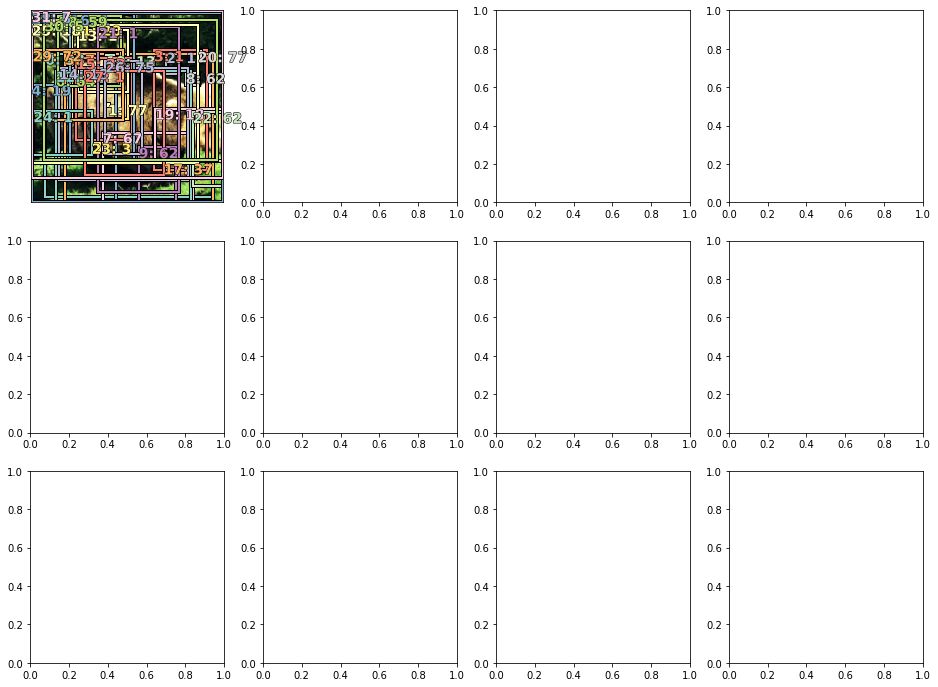

In [82]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
x1 = md.val_ds.denorm(x)
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x1[i], y[0][i], y[1][i])
plt.tight_layout()

ValueError: only one element tensors can be converted to Python scalars

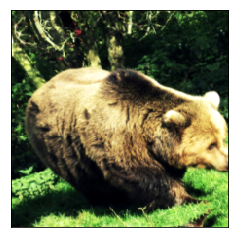

In [64]:
i = 0
ax = show_img(trn_ds.denorm(x)[i])
im0_a = [k[i] for k in y]
im0_b = [k[i] for k in im0_a]
b = bb_hw(im0_a[0])
draw_rect(ax, b)
# draw_text(ax, b[:2], 'dog')
draw_text(ax, b[:2], cat_map[str(lab2cat[im0_a[1].cpu().numpy().item()])])

In [ ]:
# takes time, don't run normally
idx=5
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    y1 = [k[idx] for k in y]
    b = bb_hw(to_np(y1[0]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], cat_map[str(lab2cat[y1[1].cpu().numpy().item()])])

## Generating the Anchors

In [ ]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2,ctr+hw/2], dim=1)

In [ ]:
na = 9
anc_grids = [int(np.ceil(sz / 2**i)) for i in range(3, 8)]
# anc_grids = [int(np.ceil(sz / 2**i)) for i in range(4, 5)]
anc_zooms = [1., 2**(1/3), 2**(2/3)]
anc_ratios = [(1.,1.), (1.,2), (2,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
anc_offsets = [1/(o*2) for o in anc_grids]

anc_x = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), na, axis=0)
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
print(anchors.size())
anc_ctrs.shape, anc_sizes.shape
# anc_grid = 4
# na = 1

# anc_offset = 1/(anc_grid*2)
# anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
# anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

# anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (na,1))
# anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
# anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
# grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)
# anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
# anchors.size()

In [ ]:
a=np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

In [62]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    ind = np.random.permutation(len(bb))
    
#     for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
    for ii, i in enumerate(ind):
        b = bb[i]
        c = clas[i]
        pr = prs[i]
        if ii > 10:
            break
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
# fig, ax = plt.subplots(figsize=(7,7))
# show_ground_truth(ax, md.aug_dl.dataset.denorm(x)[4], a)

In [ ]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

## Creating the Model

### Backbone

In [ ]:
res50 = resnet50(pretrained=True)

In [ ]:
learn_tmp = ConvLearner.pretrained(resnet50, md)

In [ ]:
learn_tmp.unfreeze()

In [ ]:
learn_tmp.summary()

### FPN

In [ ]:
def pad_out(k):
    return (k-1)//2

In [ ]:
class FPN_backbone(nn.Module):
    def __init__(self, inch_list):
        super().__init__()
        
#         self.backbone = backbone
        
        # expects c3, c4, c5 channel dims
        self.inch_list = inch_list
        self.feat_size = 256
        self.p7_gen = nn.Conv2d(in_channels=self.feat_size, out_channels=self.feat_size, stride=2, kernel_size=3,
                               padding=1)
        self.p6_gen = nn.Conv2d(in_channels=self.inch_list[2], 
                            out_channels=self.feat_size, kernel_size=3, stride=2, padding=pad_out(3))
        self.p5_gen1 = nn.Conv2d(in_channels=self.inch_list[2], 
                                 out_channels=self.feat_size, kernel_size=1, padding=pad_out(1))
#         self.p5_gen2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.p5_gen3 = nn.Conv2d(in_channels=self.feat_size, out_channels=self.feat_size,
                                kernel_size=3, padding=pad_out(3))
        
        self.p4_gen1 = nn.Conv2d(in_channels=self.inch_list[1], out_channels=self.feat_size, kernel_size=1,
                                padding=pad_out(1))
#         self.p4_gen2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.p4_gen3 = nn.Conv2d(in_channels=self.feat_size, out_channels=self.feat_size, kernel_size=3, 
                                padding=pad_out(3))
        
        self.p3_gen1 = nn.Conv2d(in_channels=self.inch_list[0], out_channels=self.feat_size, kernel_size=1,
                                padding=pad_out(1))
        self.p3_gen2 = nn.Conv2d(in_channels=self.feat_size, out_channels=self.feat_size, kernel_size=3,
                                padding=pad_out(3))
        
    def forward(self, inp):
        # expects inp to be output of c3, c4, c5
        c3 = inp[0]
        c4 = inp[1]
        c5 = inp[2]
        p51 = self.p5_gen1(c5)
        p5_out = self.p5_gen3(p51)
        
#         p5_up = self.p5_gen2(p51)
        p5_up = F.interpolate(p51, scale_factor=2)
        p41 = self.p4_gen1(c4) + p5_up
        p4_out = self.p4_gen3(p41)
        
#         p4_up = self.p4_gen2(p41)
        p4_up = F.interpolate(p41, scale_factor=2)
        p31 = self.p3_gen1(c3) + p4_up
        p3_out = self.p3_gen2(p31)
        
        p6_out = self.p6_gen(c5)
        
        p7_out = self.p7_gen(F.relu(p6_out))
        
        return [p3_out, p4_out, p5_out, p6_out, p7_out]
        

In [ ]:
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [ ]:
def initialize_vals(mdl):
    for m in mdl.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
    

In [ ]:
class classf_model(nn.Module):
    def __init__(self, fs=256, na=9, nc=80):
        super().__init__()
        self.na = na
        self.nc = nc
        self.feat_size = fs
        self.cls_modl = nn.Sequential(*nn.ModuleList([nn.Conv2d(in_channels=self.feat_size,
                                                                           out_channels=self.feat_size,
                                                                           kernel_size=3, padding=1)]*4),
                                                  nn.Conv2d(in_channels=self.feat_size,
                                                            out_channels=self.na * self.nc,
                                                            kernel_size=3, padding=1))
        initialize_vals(self.cls_modl)
    def forward(self, inp):
#         import pdb; pdb.set_trace();
        out = self.cls_modl(inp)
        out2 = flatten_conv(out, self.na)
        return out2

In [ ]:
class regress_model(nn.Module):
    def __init__(self, fs=256, na=9, nc=80):
        super().__init__()
        self.na = na
        self.nc = nc
        self.feat_size = fs
        self.reg_model = nn.Sequential(*nn.ModuleList([nn.Conv2d(in_channels=self.feat_size,
                                                                           out_channels=self.feat_size,
                                                                           kernel_size=3, padding=1)]*4),
                                                  nn.Conv2d(in_channels=self.feat_size,
                                                            out_channels=self.na * 4,
                                                            kernel_size=3, padding=1))
        initialize_vals(self.reg_model)
    def forward(self, inp):
        out = self.reg_model(inp)
        out2 = flatten_conv(out, self.na)
        return out2

In [ ]:
class retina_net_model(nn.Module):
    def __init__(self, resnet_model, na=9):
        super().__init__()
        self.res_backbone = resnet_model
        self.fpn_sizes = [self.res_backbone.layer2[-1].conv3.out_channels, 
                          self.res_backbone.layer3[-1].conv3.out_channels,
                          self.res_backbone.layer4[-1].conv3.out_channels]
        self.feat_size = 256
        self.num_anch = na
        self.num_class = 80
        self.fpn = FPN_backbone(self.fpn_sizes)
        self.cls_model = classf_model(self.feat_size, self.num_anch, self.num_class)
        self.reg_model = regress_model(self.feat_size, self.num_anch, self.num_class)
        
        
    def forward(self, inp):
        x = self.res_backbone.conv1(inp)
        x = self.res_backbone.bn1(x)
        x = self.res_backbone.relu(x)
        x = self.res_backbone.maxpool(x)
        x1 = self.res_backbone.layer1(x)
        x2 = self.res_backbone.layer2(x1)
        x3 = self.res_backbone.layer3(x2)
        x4 = self.res_backbone.layer4(x3)

        features = self.fpn([x2, x3, x4])
        out_cls = []
        out_bbx = []
        for p in features:
            out_cls.append(self.cls_model(p))
            out_bbx.append(self.reg_model(p))
        
        return [torch.cat(out_cls, dim=1),
                torch.cat(out_bbx, dim=1)]

In [ ]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

In [ ]:
class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
#         x = pred[:,:-1]
        x = pred
        w = self.get_weight(x,t)
#         import pdb; pdb.set_trace()
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None
    
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [ ]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
#     bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
#     return bbox[bb_keep],clas[bb_keep]
    return bbox, clas

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

In [ ]:
loss_f = BCE_Loss(len(cat2lab))
# loss_f = nn.CrossEntropyLoss()

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
#     import pdb; pdb.set_trace()

    bbox,clas = get_y(bbox,clas)

    a_ic = actn_to_bb(b_bb, anchors)

    overlaps = jaccard(bbox.data, anchor_cnr.data)
    
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
#     gt_clas = clas[gt_idx]
#     gt_clas = clas
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
#     gt_clas[1-pos] = len(id2cat)
    gt_clas = torch.zeros(len(b_c)).type(torch.cuda.LongTensor)
    gt_clas[1 - pos] = len(cat2lab)
    
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
#     if print_it: 
    print(f'loc: {lls.data}, clas: {lcs.data}')
    return lls+lcs

In [ ]:
retina_model = retina_net_model(res50, na)
learn = ConvLearner.from_model_data(retina_model, md)
learn.crit = ssd_loss
learn.opt_fn = optim.Adam
learn.fit(1e-3, 1, cycle_len=1)